### Train Flow Matching Model

In [3]:
import sys
sys.path.append("..")  # Add parent directory to Python path

In [4]:
import torch
import torch.nn as nn
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [ ]:
# Define the velocity model
class Flow(ModelWrapper):
    def __init__(self, dim=2, h=64):
        super().__init__(self)
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )

    def forward(self, x, t):
        # Expand t to match the batch size of x
        # print(f"Before transform t has shape {t.shape}")
        t = t.view(-1, 1).expand(*x.shape[:-1], -1)   
            ## t (1,1) -> t.view(-1,1) shape (1,1)；  x shape (256,2);  
            ## ".expand"(256, -1)意思是，把第一个dimension扩展到256，第二个维度保持不变
        # print(f"After transform t has shape {t.shape}")
        return self.net(torch.cat((t, x), dim=-1))

In [20]:
# Initialize model, optimizer, and loss function
velocity_model = Flow()
optimizer = torch.optim.Adam(velocity_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

# Training loop
for iter in range(10000):
    x_1 = torch.tensor(make_moons(256, noise=0.05)[0], dtype=torch.float32) # shape (256, 2)
    x_0 = torch.randn_like(x_1) # shape (256, 2)
    t = torch.rand(x_1.shape[0], 1)  # shape (256, 1)

    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0  # True velocity
    ut = dx_t  # Because dxt/dt = x_1 - x_0 for linear path

    optimizer.zero_grad()
    pred = velocity_model(x_t, t)
    loss = loss_fn(pred, ut)
    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Step {iter}, Loss: {loss.item():.4f}")

Step 0, Loss: 1.7350
Step 1000, Loss: 1.0172
Step 2000, Loss: 0.9104
Step 3000, Loss: 1.0160
Step 4000, Loss: 0.9691
Step 5000, Loss: 0.8922
Step 6000, Loss: 0.8247
Step 7000, Loss: 0.8912
Step 8000, Loss: 0.9136
Step 9000, Loss: 0.9593


### Sampling using the learned flow (ODESolver)

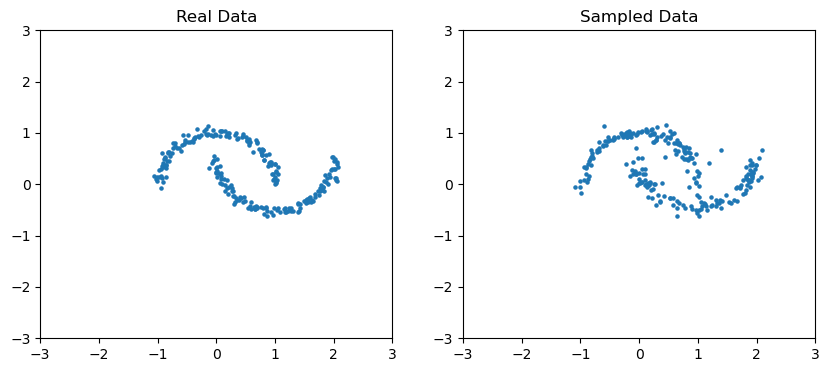

In [21]:
# Sampling using the learned flow
batch_size = 256
data_dim = (2,)
x_0 = torch.randn(batch_size, *data_dim)
solver = ODESolver(velocity_model=velocity_model)  # velocity_model needs to be a method that intakes x (batch_size, dim) and t (batch_size, 1) and returns the velocity (batch_size, dim)
num_steps = 11
x_1_sampled = solver.sample(x_init=x_0, method='midpoint', step_size = 1.0 / num_steps)

# Plot results
x_real = make_moons(256, noise=0.05)[0]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Real Data")
plt.scatter(x_real[:, 0], x_real[:, 1], s=5)
plt.ylim(-3,3)
plt.xlim(-3,3)

plt.subplot(1, 2, 2)
plt.title("Sampled Data")
plt.scatter(x_1_sampled[:, 0].detach(), x_1_sampled[:, 1].detach(), s=5)
plt.ylim(-3,3)
plt.xlim(-3,3)
plt.show()

### Compute likelihood of sampled point

In [ ]:
from torch.distributions.normal import Normal

x_1_rnd = torch.randn(batch_size, *data_dim)
x_1_moon = torch.tensor(make_moons(batch_size, noise=0.05)[0], dtype=torch.float32)

# Define logp_0(x)

base_dist = Normal(torch.zeros(size=data_dim),
                   torch.ones(size=data_dim))  # data_dim = (2,). base_dist is 2D standard Gaussian

def gaussian_log_density(x):
    """
    Computes the log density of a Gaussian distribution.
    Args:
        x: Tensor of shape [batch_size, *data_dim]
    Returns:
        log density of the Gaussian distribution evaluated at x. [batch_size, ]
    """
    # log_prob returns [batch_size, 2] (each point in batch, outputs the log prob of each dimension... so need sum up!)
    return base_dist.log_prob(x).sum(dim=tuple(range(1, x.ndim)))   

solver = ODESolver(velocity_model=velocity_model)
num_steps = 100
x_0, log_p1 = solver.compute_likelihood(
    x_1 = x_1_rnd,
    method='midpoint',
    step_size=1.0 / num_steps,
    log_p0=gaussian_log_density
)
log_p1

tensor([ -5.6555,  -1.6604,   0.7272,  -2.0223,   0.5890, -14.4670, -11.8622,
        -22.6444, -16.1684, -12.3833,  -2.3900, -30.2402, -50.3595, -14.4694,
        -11.0915,  -2.3823,  -1.2215,  -2.9786, -33.8555, -23.4131,  -5.8988,
        -15.3860, -13.1927,   2.0120, -51.9332,  -2.7571, -10.2669, -10.2655,
         -3.9151,  -3.9068, -16.7831,  -3.5927,   0.8125, -75.4118, -48.5771,
        -70.6371,  -9.5795, -19.3716, -17.0867,  -1.1609,  -5.1844,  -0.6062,
        -30.9647,  -3.3757, -20.0753,  -3.5145,  -3.2847, -40.7229, -25.7585,
         -1.9466,  -0.7021,  -3.6416,  -4.5788,  -5.0180,  -1.0921, -22.4995,
         -2.4688,  -9.8078,  -3.1984,   1.8732, -32.2310,  -3.5684,  -2.9242,
        -12.1941,  -8.9877,   1.4663, -16.6503,  -3.6278,  -9.5597, -11.7608,
         -2.4423,  -5.0904,  -7.0458, -13.4968, -43.6779, -16.5601,  -6.7235,
         -0.1067, -25.5708,  -2.3532, -82.3251, -10.7971,  -5.2049, -27.6323,
          0.2753, -20.9760, -13.7082,  -6.9853,  -1.4718,  -0.87

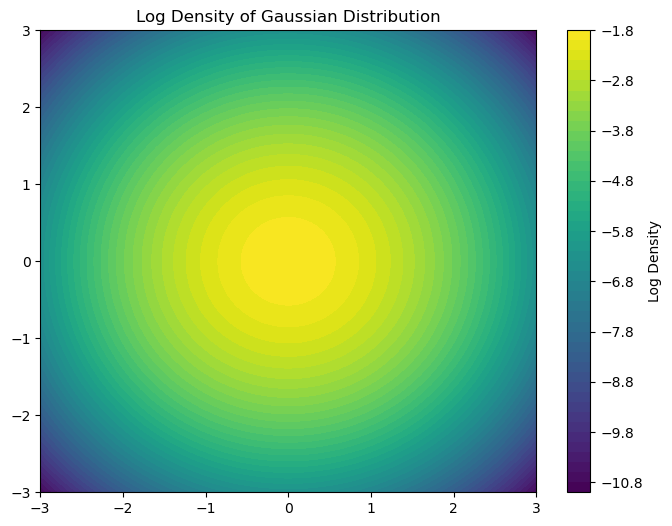

In [46]:
# The Log density of the original Gaussian distribution

x_space = torch.linspace(-3, 3, 100)
y_space = torch.linspace(-3, 3, 100)
X, Y = torch.meshgrid(x_space, y_space)
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1)
p = gaussian_log_density(grid_points)

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, p.view(X.shape), levels=50, cmap='viridis')
plt.colorbar(label='Log Density')
plt.title('Log Density of Gaussian Distribution')
plt.show()